In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import imp
import numpy as np
from scipy import constants

import lsst.daf.persistence as daf_persistence
from lsst.sims.photUtils import Bandpass, PhotometricParameters
from lsst.utils import getPackageDir

In [3]:
def rebin(image, resolution=2, mode='linear', center=False):
    y_size_old, x_size_old = image.shape
    y_size_new = y_size_old*resolution
    x_size_new = x_size_old*resolution
    image_new = np.zeros((y_size_new, x_size_new), dtype=image.dtype)
    if mode == 'linear':
        image_pad = np.pad(image, ((0, 1), (0, 1)), mode='edge')
        for j in range(resolution):
            j0 = j
            j1 = resolution - j0
            for i in range(resolution):
                i0 = i
                i1 = resolution - i0
                image_new[j::resolution, i::resolution] = ((j0*i0*image_pad[1:, 1:] + j1*i0*image_pad[:-1, 1:]
                                                           + j0*i1*image_pad[1:, :-1] + j1*i1*image_pad[:-1, :-1])/
                                                           (j0*i0 + j1*i0 + j0*i1 + j1*i1))
        if center:
            image_new = np.pad(image_new, ((resolution//2, 0), (resolution//2, 0)), 'edge')[0:y_size_new, 0:x_size_new]
    elif mode == 'constant':
        for j in range(resolution):
            for i in range(resolution):
                image_new[j::resolution, i::resolution] = image
    return image_new

In [4]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(16, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
#     img_use = np.clip(img, range[0], range[1])
    img_use = img.copy()
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
#     if preserve_scale:
#         img_use[0,0] = range[0]
#         img_use[-1,-1] = range[1]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow, clim=range)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

In [5]:
def draw_angle(image, angle=None):
    res = 4
    image_use = rebin(image, res, mode='linear', center=True)
    if angle is not None:
        angle_image = np.zeros_like(image_use)
        y_size, x_size = image_use.shape
        xc = x_size//2
        yc = y_size//2
        for i in range(xc-1):
            dx = i*np.sin(angle)
            dy = i*np.cos(angle)
            x0 = int(np.floor(dx))
            x1 = x0+2
            xfrac = dx - x0
            y0 = int(np.floor(dy))
            y1 = y0+2
            yfrac = dy - y0
            sub = [[(1-xfrac)*(1-yfrac), (1-xfrac)*yfrac], [xfrac*(1-yfrac), xfrac*yfrac]]
            angle_image[yc+y0:yc+y1, xc+x0:xc+x1] += sub
        angle_image *=np.max(image_use)/np.max(angle_image)
        image_use += angle_image
    look(image_use)

In [6]:
repository = "/Users/sullivan/LSST/DATA/Decam/Blind15A_03_new/rerun/test1/"
obsid_list = [410948, 410998, 411232, 411282, 411332, 411382, 411433, 411634, 411684]
# obsid_list=[410948, 410998, 411232, 411282, 411332, 411382, 411433, 411634, 411684, 411735, 411785, 411835, 412037, 412087, 412227, 412282]
band_name = "g"

In [7]:
from python.dcr_template import DcrCorrection
from python.dcr_template import DcrModel

In [8]:
self = DcrCorrection(n_step=3, repository=repository, obsid_range=obsid_list, band_name=band_name,
                     warp=True, instrument='decam', debug_mode=True)

In [9]:
for exp_i in range(self.n_images):
    print("Az: %3.3f, airmass %1.3f" % (self.azimuth_arr[exp_i].asDegrees(), self.airmass_arr[exp_i]))

Az: 344.135, airmass 1.140
Az: 306.018, airmass 1.330
Az: 67.887, airmass 1.660
Az: 43.020, airmass 1.230
Az: 357.913, airmass 1.130
Az: 313.969, airmass 1.250
Az: 289.785, airmass 1.770
Az: 68.019, airmass 1.670
Az: 43.332, airmass 1.230


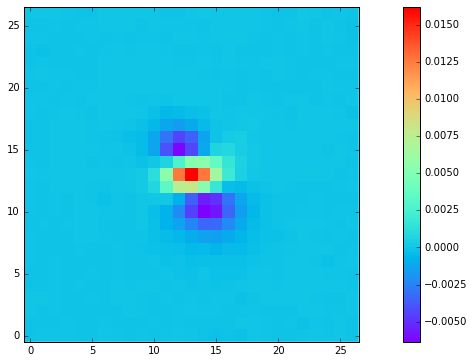

In [10]:
look(self.exposures[0].getPsf().computeKernelImage().getArray()- self.exposures[2].getPsf().computeKernelImage().getArray()[1:28, 1:28])

In [11]:
x0 = 300
dx = 200
y0 = 500
dy = 200

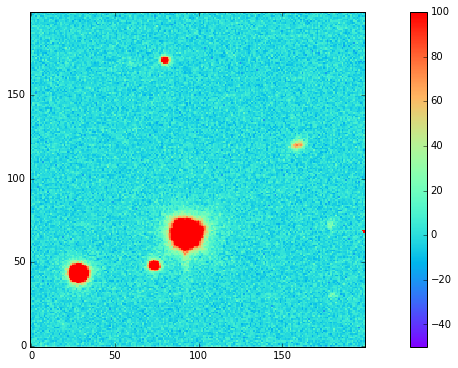

In [12]:
look(self.exposures[0].getMaskedImage().getImage().getArray(), range=[-50,100], x_range=[x0, x0+dx], y_range=[y0, y0+dy])

In [13]:
self.build_model(max_iter=20, frequency_regularization=False, test_convergence=False)

Calculating initial solution... Done!
Fractional change per iteration:
Iteration 0: delta=0.257947
Stddev(last_solution): 88.392141, mean(abs(last_solution)): 3.684043
Stddev(new_solution): 109.760702, mean(abs(new_solution)): 3.778015
Iteration 1: delta=0.163463
Stddev(last_solution): 109.760702, mean(abs(last_solution)): 3.778015
Stddev(new_solution): 131.399921, mean(abs(new_solution)): 3.846051
Iteration 2: delta=0.115850
Stddev(last_solution): 131.399921, mean(abs(last_solution)): 3.846051
Stddev(new_solution): 144.407227, mean(abs(new_solution)): 3.889266
Iteration 3: delta=0.084614
Stddev(last_solution): 144.407227, mean(abs(last_solution)): 3.889266
Stddev(new_solution): 151.401755, mean(abs(new_solution)): 3.906044
Iteration 4: delta=0.065341
Stddev(last_solution): 151.401755, mean(abs(last_solution)): 3.906044
Stddev(new_solution): 155.355085, mean(abs(new_solution)): 3.915343
Iteration 5: delta=0.053141
Stddev(last_solution): 155.355085, mean(abs(last_solution)): 3.915343
St

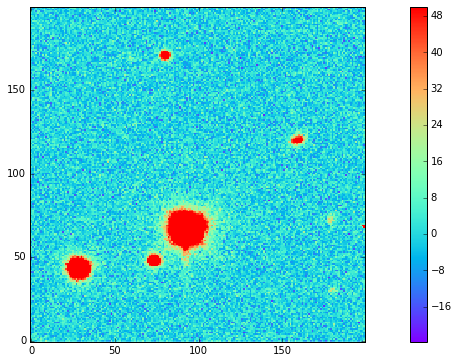

('max: ', 8668.8809, 'sum: ', 416725.75)
Matched-scale SUM


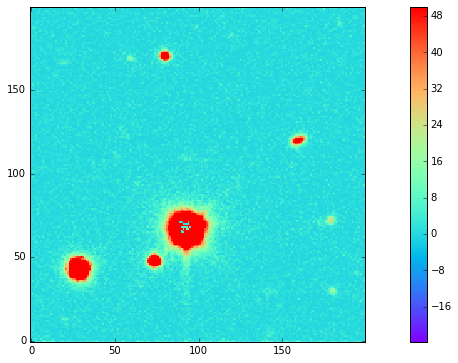

('max: ', 39159.696795760166, 'sum: ', 710723.28346614249)


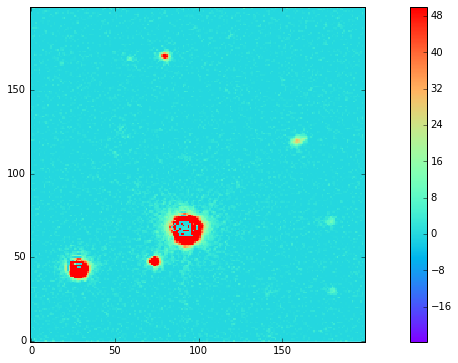

('max: ', 21469.235833302919, 'sum: ', 233877.43525094082)


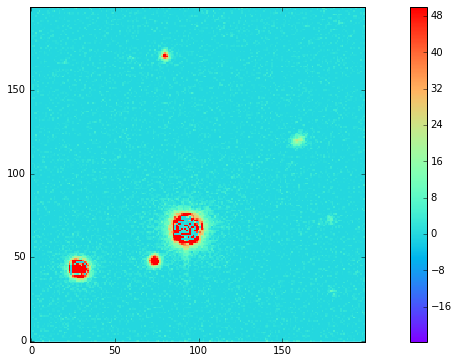

('max: ', 29373.770054581044, 'sum: ', 270485.49842960236)


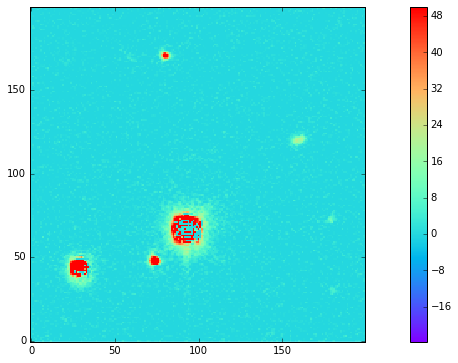

('max: ', 20815.648787983984, 'sum: ', 206360.34978559925)
SUM


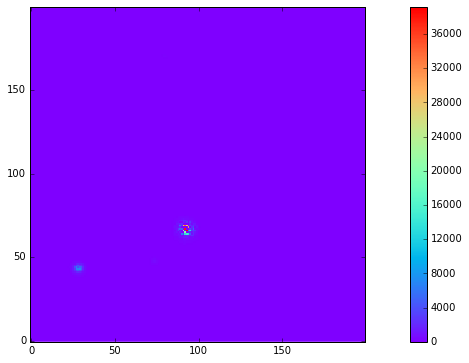

('max: ', 39159.696795760166, 'sum: ', 710723.28346614249)
DIFF last - first


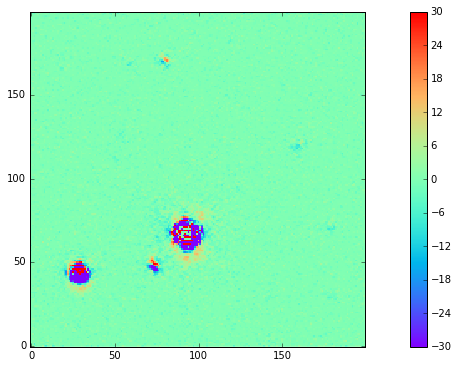

DIFF second - first


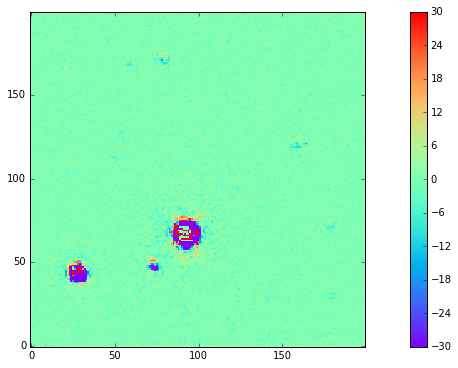

DIFF last - second to last


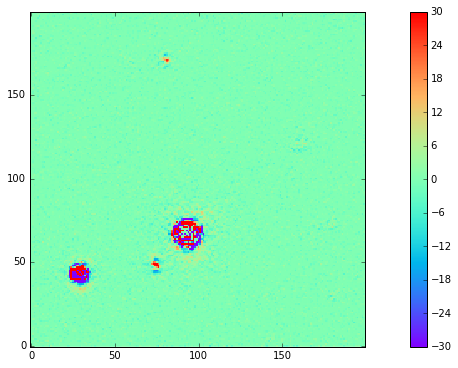

In [14]:
x0 = 300
y0 = 500
slice_inds = np.s_[y0: y0 + dy, x0: x0 +dx]
ref_im = self.exposures[0].getMaskedImage().getImage().getArray()[slice_inds]
if self.debug:
    x0 = y0 = 0
    slice_inds = np.s_[y0: y0 + dy, x0: x0 +dx]
min_use = np.min([np.min(ref_im),50.])
look(ref_im, range=[min_use,50])
print("max: ", np.max(ref_im), "sum: ", np.sum(ref_im))
rescale = 1.
sum_im = np.sum([self.model[_i]*rescale for _i in range(self.n_step)],axis=0)
print("Matched-scale SUM")
look(sum_im,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[min_use,50])
print("max: ", np.max(sum_im[slice_inds]), "sum: ", np.sum(sum_im[slice_inds]))
for _i in range(self.n_step):
    look(self.model[_i]*rescale,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[min_use,50])
    print("max: ", np.max(self.model[_i][slice_inds]*rescale),
          "sum: ", np.sum(self.model[_i][slice_inds]*rescale))
print("SUM")
look(sum_im,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy])
print("max: ", np.max(sum_im[slice_inds]), "sum: ", np.sum(sum_im[slice_inds]))

diff_range = [-30, 30]
print("DIFF last - first")
look((self.model[-1] - self.model[0])*rescale,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy],range=diff_range)
print("DIFF second - first")
look((self.model[1] - self.model[0])*rescale,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy],range=diff_range)
print("DIFF last - second to last")
look((self.model[-1] - self.model[-2])*rescale,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy],range=diff_range)

In [15]:
output_directory='/Users/sullivan/LSST/DATA/Decam/Blind15A_03_new/rerun/test1/'
template_exposure_gen = self.generate_templates_from_model(obsid_range=obsid_list[0:4],output_repository=None,
                                                           instrument='decam',warp=True, output_obsid_offset=2000000)
im_arr = []
for exp in template_exposure_gen:
    im_arr.append(exp.getMaskedImage().getImage().getArray())

Working on observation 410948 ... Done!
Working on observation 410998 ... Done!
Working on observation 411232 ... Done!
Working on observation 411282 ... Done!


self.export_model(model_repository=output_directory)

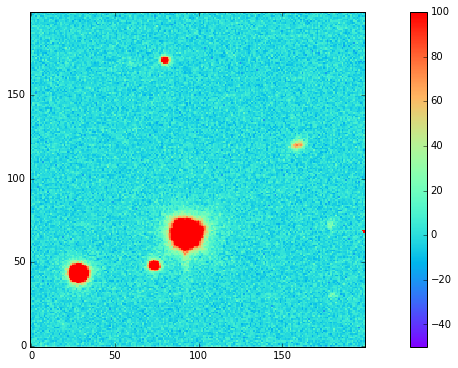

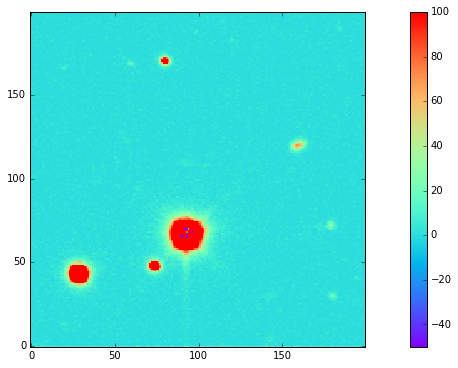

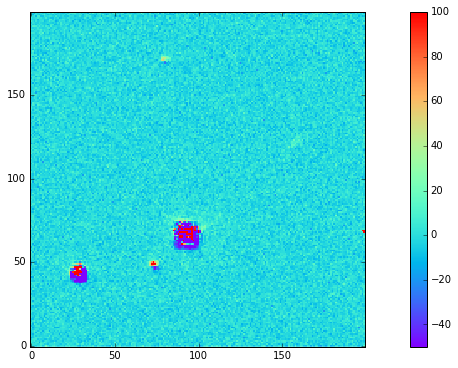

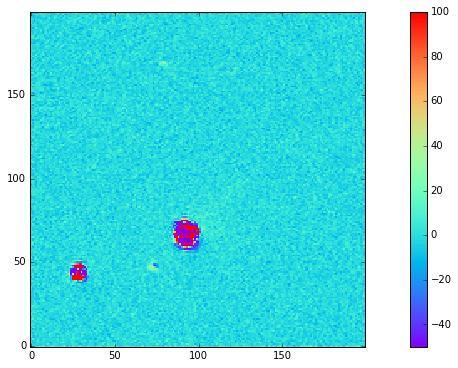

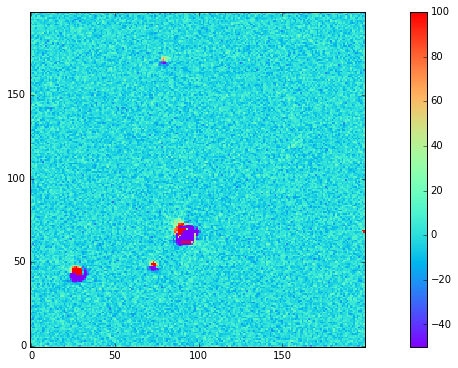

In [17]:
x0 = 300
y0 = 500
exp_i = 0
from python.dcr_template import wrap_warpExposure
ref_exp0 = self.exposures[exp_i] #self.butler.get("calexp", dataId={'visit': obsid_list[exp_i], 'ccdnum': 10})
ref_exp1 = self.exposures[exp_i+1] #self.butler.get("calexp", dataId={'visit': obsid_list[exp_i + 1], 'ccdnum': 10})
# ref_exp0 = self.butler.get("calexp", dataId={'visit': 411433, 'ccdnum': 10})
# ref_exp1 = self.butler.get("calexp", dataId={'visit': 411835, 'ccdnum': 10})
# wrap_warpExposure(ref_exp0, self.wcs, self.bbox)
# wrap_warpExposure(ref_exp1, self.wcs, self.bbox)
rescale = 1.
look(ref_exp0.getMaskedImage().getImage().getArray(),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[-50,100])
look(im_arr[exp_i]*rescale,x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[-50,100])
look(ref_exp0.getMaskedImage().getImage().getArray() - im_arr[exp_i]*rescale,
     x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[-50,100])
look(ref_exp1.getMaskedImage().getImage().getArray() - im_arr[1]*rescale,
     x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[-50,100])
look(ref_exp0.getMaskedImage().getImage().getArray()
     - ref_exp1.getMaskedImage().getImage().getArray(),
     x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[-50,100])

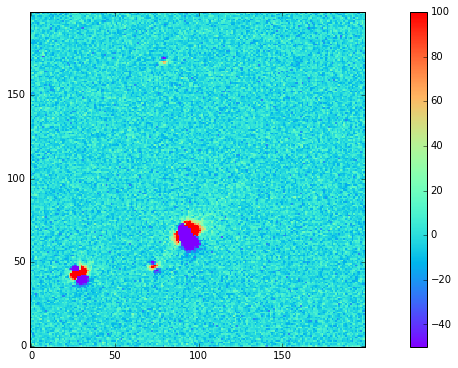

In [28]:
exp_i1 = 1
exp_i2 = 2
look(self.exposures[exp_i1].getMaskedImage().getImage().getArray() - 
     self.exposures[exp_i2].getMaskedImage().getImage().getArray(),x_range=[x0, x0 + dx], y_range=[y0, y0 + dy], range=[-50,100])

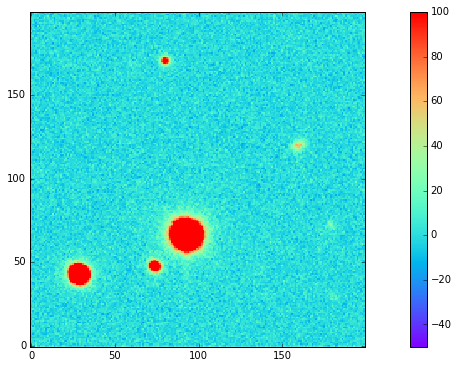

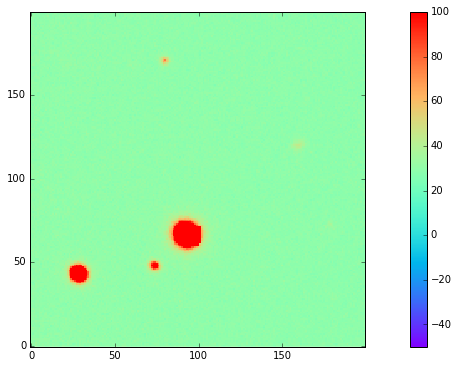

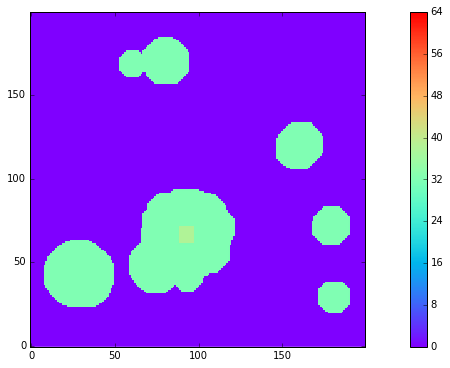

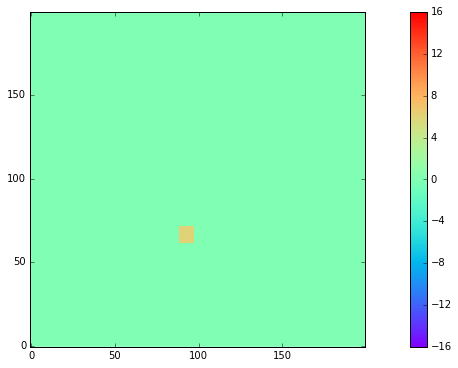

In [50]:
exp_i = 8
look(self.exposures[exp_i].getMaskedImage().getImage().getArray(), range=[-50,100], x_range=[x0, x0+dx], y_range=[y0, y0+dy])
look(self.exposures[exp_i].getMaskedImage().getVariance().getArray(), range=[-50,100], x_range=[x0, x0+dx], y_range=[y0, y0+dy])
look(self.exposures[exp_i].getMaskedImage().getMask().getArray(), x_range=[x0, x0+dx], y_range=[y0, y0+dy], range=[0,64])
look((self.exposures[exp_i].getMaskedImage().getMask().getArray() | 32)-32, x_range=[x0, x0+dx], y_range=[y0, y0+dy], range=[-16,16])

In [23]:
butler = daf_persistence.Butler(repository)

In [59]:
obsid_list = ([406289, 410842, 410948, 410998, 411232, 411282, 411332, 411382, 411433, 411634, 411684, 411735, 411785, 411835, 412037, 412087,
              412227, 412282, 412481, 412531, 412581, 412631, 412681, 413562, 413612, 413657, 415256, 415291, 415341, 419369, 419777, 421527, 421573])

In [24]:
def parallactic_angle(hour_angle, dec, lat):
    return np.arctan2(np.sin(hour_angle), np.cos(dec)*np.tan(lat) - np.sin(dec)*np.cos(hour_angle))

In [25]:
filter_list = []
vinfo_list = []
wcs_list = []
rot_list = []
pa_list = []
airmass_list = []
for visit in obsid_list:
    if butler.datasetExists("calexp", dataId={'visit': visit, 'ccdnum': 10}):
        calexp = butler.get("calexp", dataId={'visit': visit, 'ccdnum': 10})
    else:
        print(visit, "missing calexp, skipping")
        continue
    psf_size = np.sqrt(calexp.getPsf().computeShape().getArea())
    f_name = calexp.getInfo().getFilter().getName()
    filter_list.append(f_name)
    vinfo = calexp.getInfo().getVisitInfo()
    vinfo_list.append(vinfo)
    wcs = calexp.getInfo().getWcs()
    wcs_list.append(wcs)
    AzAlt=vinfo.getBoresightAzAlt()
    az = AzAlt.getLongitude()
    alt = AzAlt.getLatitude()
    hour_angle = vinfo.getBoresightHourAngle()
    dec = vinfo.getBoresightRaDec().getDec()
    lat = vinfo.getObservatory().getLatitude()
    airmass = vinfo.getBoresightAirmass()
    airmass_list.append(airmass)
    cd = wcs.getCDMatrix()
    cd_rot = (np.arctan2(-cd[0, 1], cd[0, 0]) + np.arctan2(cd[1, 0], cd[1, 1]))/2.
    rot_list.append(cd_rot)
    p_angle = parallactic_angle(hour_angle.asRadians(), dec.asRadians(), lat.asRadians())
    pa_list.append(p_angle)
    print(visit, f_name, airmass, psf_size, cd_rot*180./np.pi, p_angle*180./np.pi, az*180./np.pi)

(410948, 'g', 1.14, 2.6102392127286613, -90.022559365393818, 166.16781006848751, 344.135 rad)
(410998, 'g', 1.33, 2.7682508193365725, -90.012338276169473, 135.56278929122678, 306.018 rad)
(411232, 'g', 1.66, 3.0131419568864506, -90.03557715319937, -126.78429738625411, 67.8874 rad)
(411282, 'g', 1.23, 2.3531329897009452, -90.034579525810614, -143.97873250892229, 43.0196 rad)
(411332, 'g', 1.13, 2.2658921351292696, -90.026015497868229, 178.00684283931182, 357.913 rad)
(411382, 'g', 1.25, 2.2763368903779577, -90.015611284576948, 141.43938023730482, 313.969 rad)
(411433, 'g', 1.77, 3.4674527766790657, -90.009245902709139, 125.4969625073912, 289.785 rad)
(411634, 'g', 1.67, 3.968864963685339, -90.036339601899527, -126.71261948426876, 68.0188 rad)
(411684, 'g', 1.23, 3.2559713386298643, -90.036025716654109, -143.7333911031715, 43.3321 rad)
(411735, 'g', 1.13, 2.9430483437735688, -90.027668199600754, 177.56753285046389, 357.404 rad)
(411785, 'g', 1.25, 2.945238043522624, -90.017077009373168, 

In [21]:
obsid_list=[410948, 410998, 411232, 411282, 411332, 411382, 411433, 411634, 411684, 411735, 411785, 411835, 412037, 412087, 412227, 412282]

In [8]:
obsid_list = [410948, 410998, 411232, 411282, 411332]

In [ ]:
obsid_list = [410948, 410998, 411232, 411282, 411332, 411382, 411433, 411634, 411684]

In [198]:
import lsst.afw.image as afwImage
exposures = []
exp_i = -1
for visit in obsid_list:
    if butler.datasetExists("calexp", dataId={'visit': visit, 'ccdnum': 10}):
        calexp = butler.get("calexp", dataId={'visit': visit, 'ccdnum': 10})
    else:
        print(visit, "missing calexp, skipping")
        continue
    exp_i += 1
    f_name = calexp.getInfo().getFilter().getName()
    filter_list.append(f_name)
    vinfo = calexp.getInfo().getVisitInfo()
    vinfo_list.append(vinfo)
    wcs = calexp.getInfo().getWcs()
    wcs_list.append(wcs)
    AzAlt=vinfo.getBoresightAzAlt()
    az = AzAlt.getLongitude()
    alt = AzAlt.getLatitude()
    hour_angle = vinfo.getBoresightHourAngle()
    dec = vinfo.getBoresightRaDec().getDec()
    lat = vinfo.getObservatory().getLatitude()
    airmass = vinfo.getBoresightAirmass()
    airmass_list.append(airmass)
    cd = wcs.getCDMatrix()
    cd_rot = (np.arctan2(-cd[0, 1], cd[0, 0]) + np.arctan2(cd[1, 0], cd[1, 1]))/2.
    rot_list.append(cd_rot)
    p_angle = parallactic_angle(hour_angle.asRadians(), dec.asRadians(), lat.asRadians())
    pa_list.append(p_angle)
    print(visit, f_name, airmass, cd_rot, p_angle)
    if exp_i == 0:
        exposures.append(calexp)
    else:
        afwWarpedExposure = afwImage.ExposureF(exposures[0].getBBox(), exposures[0].getWcs())
        afwMath.warpExposure(afwWarpedExposure, calexp, warpingControl)
        exposures.append(afwWarpedExposure)

(410948, 'g', 1.14, -1.5711900619981791, 2.9001753965236912)
(410998, 'g', 1.33, -1.5710116703380743, 2.3660170163192173)
(411232, 'g', 1.66, -1.571417265256712, -2.2128034292177752)
(411282, 'g', 1.23, -1.5713998533740701, -2.5129029351288903)
(411332, 'g', 1.13, -1.5712503828892428, 3.1068054986260831)


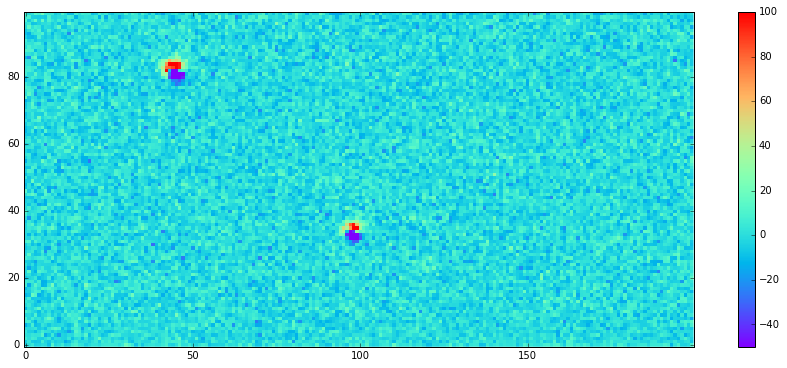

In [204]:
look(exposures[0].getMaskedImage().getImage().getArray() - exposures[3].getMaskedImage().getImage().getArray(), range=[-50, 100], x_range=[100, 300], y_range=[0,100])

In [73]:
wmeta.names()

('CTYPE1',
 'CRVAL2',
 'CRVAL1',
 'CD2_2',
 'CD2_1',
 'CTYPE2',
 'CUNIT1',
 'CD1_2',
 'RADESYS',
 'CRPIX1',
 'CRPIX2',
 'CUNIT2',
 'NAXIS',
 'CD1_1')

In [138]:
wmeta.get("CRVAL1")

138.3795270907

In [51]:
filt = meta.getFilter().getName()

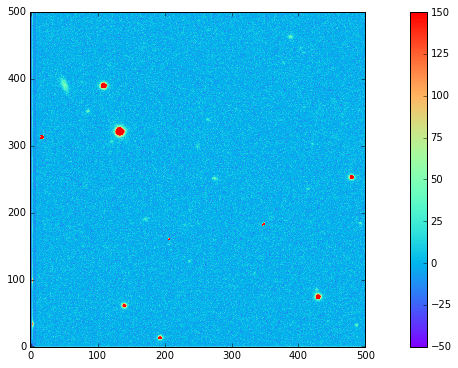

In [139]:
look(calexp.getMaskedImage().getImage().getArray(), range=[-50,150],x_range=[0,500],y_range=[0,500])

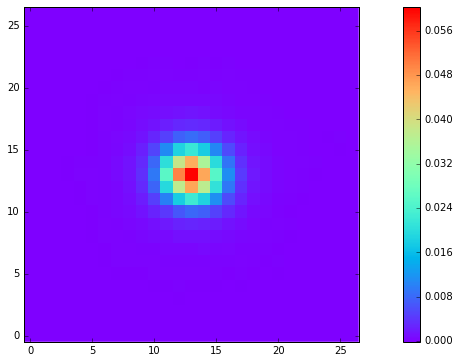

In [141]:
look(calexp.getPsf().computeKernelImage().getArray())

In [ ]:
for _i in range(self.n_step):
    look(self.psf_model[_i, :, :])
    print(np.max(self.psf_model[_i, :, :]), np.sum(self.psf_model[_i, :, :]))
print("SUM")
look(np.sum(self.psf_model,axis=0))
print(np.max(np.sum(self.psf_model,axis=0)))
print("DIFF")
look(self.psf_model[0, :, :] - self.psf_model[-1, :, :])

In [ ]:
self.build_model(use_full=False, use_regularization=True, use_only_detected=False, use_nonnegative=False, positive_regularization=False)